<a href="https://colab.research.google.com/github/AdriaSoria/DL_FinalProject/blob/main/DL_FinalProject_(First_Approach).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <font color=CC0000> **Deep Learning**
## <font color=CC0000> **Final Project: Energy Consumption Prediction**

**P103 - Team L**

*   Adrià Soria - 251729
*   Judit Viladecans - 251437
*   Paula Ceprián - 252503

# 0. Introduction

This implementation presents a deep learning solution for predicting household electricity consumption patterns using Long Short-Term Memory (LSTM) networks. The primary objective is to forecast future power consumption values based on historical usage data, helping to anticipate energy demands at the household level. By analyzing temporal sequences of power-related features including global active power, reactive power, voltage, and current intensity, the model learns to recognize and predict consumption patterns across different time periods. This predictive capability has practical applications in smart home energy management, helping households optimize their energy usage and potentially reduce costs.

The focus here is to:

- **Train and run** a predictive model using  a sequence-to-sequence architecture with LSTM neural networks to forecast household electricity consumption.
- **Iteratively enhance the basic LSTM architecture** through various optimization strategies to maximize prediction accuracy.
- **Exploration of advanced features in the model design**, such as stateful LSTM layers and time series cross-validation, to improve upon the basic implementation and achieve more robust predictions.

# 1. Model Design

### 1.1. Import Basic Libraries and Dataset
In this section, we import the essential libraries for the model architecture design. The `clean_dataset.csv` dataset is loaded to preprocess and start the model training.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time
import random
from math import sqrt
from collections import deque

from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics
from sklearn.metrics import mean_squared_error, r2_score, mean_squared_log_error
from sklearn.model_selection import TimeSeriesSplit


import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, Activation, Bidirectional, Input, LeakyReLU
from tensorflow.keras.layers import Flatten, TimeDistributed

from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint, EarlyStopping

from google.colab import drive
import os


In [ ]:
drive.mount('/content/drive')
project_path = '/content/drive/Shareddrives/Deep Learning 2025/UPF_Deep_Learning_2025/Project/'

os.chdir(project_path)

Mounted at /content/drive


In [ ]:
df = pd.read_csv('clean_dataset.csv', sep=',', low_memory=False, encoding='utf-8')

# Print initial data types
print("Initial data types:")
print(df.dtypes)

# 1. Handle datetime-related columns
df['Datetime'] = pd.to_datetime(df['Datetime'])  # Convert to datetime
df.set_index('Datetime', inplace=True)  # Set as index

# 2. Drop redundant time-related columns since we have datetime index
time_columns = ['Date', 'Time', 'Hour', 'Year', 'Year-Month', 'Month', 'Month-Day']
df = df.drop(time_columns, axis=1)

# 3. Drop sub-metering columns
sub_metering_columns = ['Sub Metering 1', 'Sub Metering 2', 'Sub Metering 3']
df = df.drop(sub_metering_columns, axis=1)

# 4. Clean column names (remove spaces)
df.columns = df.columns.str.replace(' ', '_')

# 5. Ensure numeric columns are float
numeric_columns = ['Global_Active_Power', 'Global_Reactive_Power', 'Voltage', 'Global_Intensity']
for col in numeric_columns:
    df[col] = df[col].astype('float64')

# 6. Sort by datetime index and handle missing values
df.sort_index(inplace=True)
df.dropna(inplace=True)

# 7. Resample to hourly data
df = df.resample('1h').mean()
df.dropna(inplace=True)

# Now extract datetime-based features from the index
df['Hour'] = df.index.hour
df['Month'] = df.index.month
df['Day'] = df.index.day

# Print final information about the dataset
print("\nFinal data types:")
print(df.dtypes)
print("\nFinal columns:")
print(df.columns.tolist())
print("\nShape of dataset:", df.shape)
print("\nFirst few rows of processed data:")
print(df.head())

print("\nDataset after preprocessing:")
print(df.head())
print("\nColumns after preprocessing:")
print(df.columns.tolist())
print("\nShape of dataset:", df.shape)

Initial data types:
Datetime                  object
Date                      object
Time                      object
Global Active Power      float64
Global Reactive Power    float64
Voltage                  float64
Global Intensity         float64
Sub Metering 1           float64
Sub Metering 2           float64
Sub Metering 3           float64
Hour                       int64
Year                       int64
Year-Month                object
Month                      int64
Month-Day                 object
dtype: object

Final data types:
Global_Active_Power      float64
Global_Reactive_Power    float64
Voltage                  float64
Global_Intensity         float64
Hour                       int32
Month                      int32
Day                        int32
dtype: object

Final columns:
['Global_Active_Power', 'Global_Reactive_Power', 'Voltage', 'Global_Intensity', 'Hour', 'Month', 'Day']

Shape of dataset: (34168, 7)

First few rows of processed data:
                     G

The dataset captures hourly household power consumption through four electrical parameters (Global Active Power, Global Reactive Power, Voltage, and Global Intensity) across 34,168 measurements starting from December 2006. The data is structured as a time series with measurements taken every hour, starting from December 16, 2006, at 17:00. These four parameters provide a comprehensive view of the household's electrical consumption patterns, which will be used by our LSTM model to learn and predict future consumption values.

In [ ]:
#### Data Preprocessing

#### Moving Average filtering... smoothing our data

######## Smothing our data at first
df = df.ewm(alpha=0.1).mean()
df.dropna(inplace=True)

# #Dropping the outlier rows with standard deviation
factor = 5
upper_lim = df['Global_Active_Power'].mean () + df['Global_Active_Power'].std () * factor
lower_lim = df['Global_Active_Power'].mean () - df['Global_Active_Power'].std () * factor
df = df[(df['Global_Active_Power'] < upper_lim) & (df['Global_Active_Power'] > lower_lim)]

####### fill values summer of 2008

times = pd.to_datetime(df.index)
times = times.strftime("%Y-%m-%d").tolist()
temp = []
for index,value in enumerate(times):
  if(value > '2007-08-08' and value <'2007-09-01'):

    #temp.append(float(df['Global_active_power'][index]))
    temp.append(float(df.loc[df.index[index], 'Global_Active_Power']))

temp = pd.Series(temp)
temp = temp.ewm(alpha=0.15).mean()
temp = temp.values

k=0
for index,value in enumerate(times):
  if(value > '2008-08-08' and value <'2008-09-01'):
    #df['Global_active_power'].iloc[index] = temp[k]
    df.loc[df.index[index], 'Global_Active_Power'] = temp[k]
    k += 1

print(f'df_shape arxika: {df.shape}\n')

df_shape arxika: (34153, 7)



We processes this time series data through several crucial steps: it first organizes the readings chronologically and standardizes the data format, then applies an exponential moving average (alpha=0.2) to smooth out short-term fluctuations in the measurements. To ensure data quality, it removes statistical outliers using a three-standard-deviation threshold and handles a specific data anomaly in the summer period of 2008 by filling it with smoothed values from the corresponding period in 2007.

### 1.2 LSTM Definition

This section presents the core functions and neural network architecture used for forecasting household power consumption. The code defines key parameters for sequence length, prediction horizon, and model training, and implements utility functions for error calculation, data preprocessing, and time series splitting. At its core, the section introduces a deep learning model based on a stateful LSTM (Long Short-Term Memory) architecture, designed to capture temporal dependencies in sequential power usage data. The model is structured to process sequences of historical measurements and predict future consumption, forming the foundation for the project's predictive analytics.

In [ ]:
def mean_absolute_percentage_error(y_true, y_pred):
#     y_true, y_pred = check_arrays(y_true, y_pred)

    ## Note: does not handle mix 1d representation
    #if _is_1d(y_true):
    #    y_true, y_pred = _check_1d_array(y_true, y_pred)

    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


def regression_accuracy(y_true, y_pred, tolerance):
    """
    Calcula la "accuracy" de un modelo de regresión como el % de predicciones
    que caen dentro de un margen relativo de tolerancia
    """
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    within_tolerance = np.abs(y_true - y_pred) <= (tolerance * np.abs(y_true))
    return np.mean(within_tolerance) * 100  # en porcentaje


def theil_u(yhat, y):

  len_yhat = len(yhat)
  sum1 = 0
  sum2 = 0

  for i in range(len_yhat-1):

    sum1 += ( (yhat[i+1] - y[i+1]) / y[i] )**2
    sum2 += ( (y[i+1] - y[i]) / y[i] )**2

  return sqrt(sum1/sum2)


def plot_history(loss, val_loss, epochs):

  plt.figure(figsize=[15,8])
  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Square Error [$MPG^2$]')
  plt.plot(range(epochs), loss, label='Train Error')
  plt.plot(range(epochs), val_loss, label = 'Val Error')
  plt.ylim([0.00,0.15])
  plt.legend()
  plt.show()


def preprocess_df(df, shuffle=False):

    sequential_data = []                    # this is a list that will CONTAIN the sequences
    prev_days = deque(maxlen = SEQ_LEN)     # These will be our actual sequences.
                                            # They are made with deque, which keeps the maximum length
                                            # by popping out older values as new ones come in
    for i in df.values:                                             # iterate over the values
        prev_days.append([n for n in i[:-1]])                       # store all but the label
        if len(prev_days) == SEQ_LEN:                               # make sure we have 30 sequences!
            sequential_data.append([np.array(prev_days), i[-1]])    # append those bad boys!


    if(shuffle == True):
      random.shuffle(sequential_data)                                 # shuffle for good measure.


    X = []
    y = []

    for seq, target in sequential_data:  # going over our new sequential data
        X.append(seq)                    # X is the sequences (features)
        y.append(target)                 # y is the targets/labels

    return np.array(X), np.array(y)  # return X and y...and make X a numpy array!


def train_length(length, batch_size):

  length_values = []
  for x in range( int(length)-100, int(length) ):
    modulo = x % batch_size
    if(modulo == 0 ):
      length_values.append(x)

  return ( max(length_values) )


def split_data(df, percent):

  length = len(df)
  test_index = int(length*percent)
  train_index = length - test_index
  test_df = df[train_index:]
  df = df[:train_index]

  return test_df, df


def get_model():

  model = Sequential([
    Input(shape=(train_x.shape[1], train_x.shape[2]), batch_size=BATCH_SIZE),
    LSTM(36, stateful=True, return_sequences=True),
    Activation('relu'),
    LSTM(36, stateful=True, return_sequences=False),
    Activation('relu'),
    Dense(1)
  ])

  """.....compile model....."""

  model.compile(loss = 'mae',
              optimizer = 'adam',
              metrics = ['mse', 'mae'])

  return model

# 2. Model Training

This section details the training procedure for the LSTM-based power consumption forecasting model. The code transforms the time series data into a supervised learning format, where the model learns to predict future power usage based on sequences of past measurements. It employs time series cross-validation to robustly assess model performance, splitting the data into training, validation, and test sets in a way that respects the temporal order of the data. During each split, the model is trained, validated, and evaluated using several performance metrics, with careful handling of data scaling and LSTM state management. This systematic approach ensures that the model is both well-trained and fairly evaluated on unseen data, providing reliable insights into its predictive capabilities.

In [ ]:
SEQ_LEN = 50                    # how long of a preceeding sequence to collect for RNN (in 1hour minutes)
FUTURE_PERIOD_PREDICT = 1       # how far into the future are we trying to predict? (in hours)
EPOCHS = 20                     # how many passes through our data
BATCH_SIZE = 64                 # how many batches? Try smaller batch if you're getting OOM (out of memory) errors.

                     Global_Active_Power    future
Datetime                                          
2006-12-16 22:00:00             3.191471  2.974897
2006-12-16 23:00:00             2.974897  2.783085
2006-12-17 00:00:00             2.783085  2.875533
2006-12-17 01:00:00             2.875533  2.677740
2006-12-17 02:00:00             2.677740  2.529743
2006-12-17 03:00:00             2.529743  2.485988
2006-12-17 04:00:00             2.485988  2.420388
2006-12-17 05:00:00             2.420388  2.275543
2006-12-17 06:00:00             2.275543  2.192996
2006-12-17 07:00:00             2.192996  2.155875
Yooooooo:(34152, 8)
df:(25614, 8)  test_df:(8538, 8)
df_shape(23053, 8)
test_shape(8538, 8)
Valid_shape(2561, 8)
train_len before:23004 test_len:8489
train_len after modulo:22976 test_len:8448
Train_x shape:(22976, 50, 7) Train_y shape:(22976,)
valid_x shape:(2496, 50, 7) valid_y shape:(2496,)
Test_x shape:(8448, 50, 7) Test_y shape:(8448,) 



Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (64, 50, 36)           │         6,336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (64, 50, 36)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (64, 36)               │        10,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (64, 36)               │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (64, 1)                │            37 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,885 (65.96 KB)

 Trainable params: 16,885 (65.96 KB)

 Non-trainable params: 0 (0.00 B)

Split: 2 Epochs: 0/20
359/359 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - loss: 0.0815 - mae: 0.0815 - mse: 0.0136 - val_loss: 0.0360 - val_mae: 0.0360 - val_mse: 0.0023
Split: 2 Epochs: 1/20
359/359 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 0.0337 - mae: 0.0337 - mse: 0.0020 - val_loss: 0.0196 - val_mae: 0.0196 - val_mse: 6.0352e-04
Split: 2 Epochs: 2/20
359/359 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.0210 - mae: 0.0210 - mse: 7.9872e-04 - val_loss: 0.0156 - val_mae: 0.0156 - val_mse: 4.7958e-04
Split: 2 Epochs: 3/20
359/359 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.0174 - mae: 0.0174 - mse: 5.6594e-04 - val_loss: 0.0138 - val_mae: 0.0138 - val_mse: 3.5919e-04
Split: 2 Epochs: 4/20
359/359 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.0161 - mae: 0.0161 - mse: 4.9693e-04 - val_loss: 0.0145 - val_mae: 0.0145 - val_mse: 3.5738e-04
Split: 2 Epochs: 5/20
359/359 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.0155 - mae: 0.0155 - mse: 4.6820e-04 - val_loss: 0.0131 - val_mae: 0.0131 - val_mse: 3.5470e

<Figure size 1500x800 with 0 Axes>

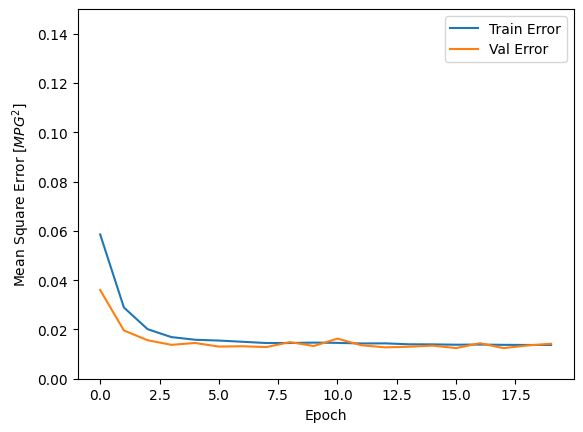

132/132 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Test RMSE: 0.053900344067924266
Test R^2 score: 0.9793679688292339
Test MAPE: 4.1046%
Test Accuracy (±10% tolerance): 93.9394%


In [ ]:
### Create supervised learning


df['future'] = df["Global_Active_Power"].shift(-FUTURE_PERIOD_PREDICT)
df.dropna(inplace=True)

print(df[['Global_Active_Power','future']].head(10))


##### cross validation for time series

count = 0

#### Evaluation metrics
evaluate_loss = []
evaluate_mse = []
evaluate_mlog = []
evaluate_rmse = []
evaluate_r2 = []
evaluate_mape = []
evaluate_accuracy = []

val_loss = []
loss = []


tscv = TimeSeriesSplit(n_splits=3)
for train_index, test_index in tscv.split(df):

  if (count >= 2 ):

    df2 = df.copy()

    print(f'df:{df2[:len(train_index)].shape}  test_df:{df2[len(train_index):len(train_index)+len(test_index)].shape}')

    test_df = df2[len(train_index):len(train_index)+len(test_index)]
    df2 = df2[:len(train_index)]
    valid_df, df2 = split_data(df2, 0.1)

    print(f'df_shape{df2.shape}')
    print(f'test_shape{test_df.shape}')
    print(f'Valid_shape{valid_df.shape}')

    df2.dropna(inplace=True)
    valid_df.dropna(inplace=True)
    test_df.dropna(inplace=True)

  #### scale our data

    scaler = MinMaxScaler(feature_range=(0, 1))

    cols = [col for col in df.columns if col not in ['time']]

    df2[cols] = scaler.fit_transform(df2[cols])
    df2.dropna(inplace=True)

    test_df[cols] = scaler.transform(test_df[cols])
    test_df.dropna(inplace=True)

    valid_df[cols] = scaler.transform(valid_df[cols])
    valid_df.dropna(inplace=True)


    train_x, train_y = preprocess_df(df2, shuffle=True)
    valid_x, valid_y = preprocess_df(valid_df, shuffle=False)
    test_x, test_y = preprocess_df(test_df, shuffle=False)

    train_len = train_x.shape[0]
    valid_len = valid_x.shape[0]
    test_len = test_x.shape[0]
    print(f'train_len before:{train_len} test_len:{test_len}')

    train_len = train_length(train_len, BATCH_SIZE)
    valid_len = train_length(valid_len, BATCH_SIZE)
    test_len = train_length(test_len, BATCH_SIZE)

    print(f'train_len after modulo:{train_len} test_len:{test_len}')

    train_x = train_x[:train_len]
    train_y = train_y[:train_len]

    valid_x = valid_x[:valid_len]
    valid_y = valid_y[:valid_len]

    test_x = test_x[:test_len]
    test_y = test_y[:test_len]

    print(f'Train_x shape:{train_x.shape} Train_y shape:{train_y.shape}')
    print(f'valid_x shape:{valid_x.shape} valid_y shape:{valid_y.shape}')
    print(f'Test_x shape:{test_x.shape} Test_y shape:{test_y.shape} \n')


    """.....The model....."""

    model = get_model()
    model.summary()

    """.....train model....."""

    #Stateful LSTM

    for i in range(EPOCHS):
      print(f'Split: {count} Epochs: {i}/{EPOCHS}')

      history = model.fit(
        train_x, train_y,
        batch_size = BATCH_SIZE,
        epochs = 1,
        validation_data = (valid_x, valid_y),
      )


      val_loss.append(history.history['val_loss'])
      loss.append(history.history['loss'])

      # Reset states for all LSTM layers
      for layer in model.layers:
          if isinstance(layer, LSTM):
              layer.reset_states()


    """ Evaluate model.......  """

    # Reset states before evaluation
    for layer in model.layers:
        if isinstance(layer, LSTM):
            layer.reset_states()

    score = model.evaluate(test_x, test_y,
                         batch_size=BATCH_SIZE,
                         verbose=0)
    print('Test loss:', score[0])
    print('Test MSE:', score[1])
    print('Test MAE:', score[2])

    evaluate_loss.append(score[0])
    evaluate_mse.append(score[1])

    ######## plot loss & val_loss

    plot_history(loss, val_loss, EPOCHS)


    #### make & evaluate our prediction

    # Reset states before prediction
    for layer in model.layers:
        if isinstance(layer, LSTM):
            layer.reset_states()

    yhat = model.predict(test_x, batch_size=BATCH_SIZE)

    ###### invert scaling for forecast
    # Create a dummy array with same shape as original data
    predict = np.zeros(shape=(len(yhat), len(df.columns)))
    # Put our predictions in the Global_active_power column position
    predict[:, df.columns.get_loc('Global_Active_Power')] = yhat[:, 0]

    inv_yhat = scaler.inverse_transform(predict)
    # Get back just the Global_active_power predictions
    inv_yhat = inv_yhat[:, df.columns.get_loc('Global_Active_Power')]

    ###### invert scaling for actual
    actual = np.zeros(shape=(len(test_y), len(df.columns)))
    actual[:, df.columns.get_loc('Global_Active_Power')] = test_y

    inv_y = scaler.inverse_transform(actual)
    inv_y = inv_y[:, df.columns.get_loc('Global_Active_Power')]

    ##### calculate RMSE
    rmse = np.sqrt(mean_squared_error(inv_y, inv_yhat))
    print(f'Test RMSE: {rmse}')
    evaluate_rmse.append(rmse)

    ##### calculate R^2 metric
    r2 = r2_score(inv_y, inv_yhat)
    print(f'Test R^2 score: {r2}')
    evaluate_r2.append(r2)

    ##### calculate MAPE
    mape = np.mean(np.abs((inv_y - inv_yhat) / inv_y)) * 100
    print(f'Test MAPE: {mape:.4f}%')
    evaluate_mape.append(mape)

    ##### calculate regression-based accuracy
    accuracy = regression_accuracy(inv_y, inv_yhat, tolerance=0.1)
    print(f'Test Accuracy (±10% tolerance): {accuracy:.4f}%')
    evaluate_accuracy.append(accuracy)

  count += 1


# 3. Model Evaluation

This section presents the aggregated results of the model’s predictive performance. By averaging key metrics across all validation splits, it provides a concise summary of how accurately the LSTM model forecasts household power consumption on unseen data.

In [ ]:
avg_loss = np.average(evaluate_loss)
avg_mse = np.average(evaluate_mse)
avg_rmse = np.average(evaluate_rmse)
avg_r2 = np.average(evaluate_r2)
avg_mape = np.average(evaluate_mape)

print('\n')
print(f'Avg Loss:{avg_loss}')
print(f'Avg MSE:{avg_mse}')
print(f'Avg RMSE:{avg_rmse}')
print(f'Avg R2:{avg_r2}')